# Homework 4: SVM


This assignment is due on Moodle by **11:59pm on Friday October 30**. 
Your solutions to theoretical questions should be done in Markdown/MathJax directly below the associated question.
Your solutions to computational questions should include any specified Python code and results 
as well as written commentary on your conclusions.
Remember that you are encouraged to discuss the problems with your instructors and classmates, 
but **you must write all code and solutions on your own**. For a refresher on the course **Collaboration Policy** click [here](https://github.com/BoulderDS/CSCI5622-Machine-Learning/blob/master/info/syllabus.md#collaboration-policy).

**NOTES**: 

- Do **NOT** load or use any Python packages that are not available in Anaconda (Version: 2019.07) with Python 3.7. 
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. 
- In this homework you will explore the primal and dual representations of support vector machines, as well as the performance of various kernels while classifying sentiments. Install the following packages: `nltk` (Version: 3.5), `scikit-learn` (Version: 0.23.2)


**Please put your name and cuidentity username.**

**Name**: Nicole Dong

**Identity Key**: 108539512

In [1]:
import math
import pickle
import gzip
import numpy as np
import pandas
import matplotlib.pylab as plt
%matplotlib inline

# Set random seed for deterministic output
np.random.seed(5622)

[40 Points] Problem 1 - Basic concepts of SVM
---

### Part 1 [10 points]
* What are the main differences between the primal and the dual representations?
* For the variables $\xi_i$, $C$ in the primal formation, what are their roles? Write out the upper/lower bounds (constraints) of these variables. What are the interpretation for these maximum/minimum values?
* For the variable $\alpha_i$, $\beta_i$ in the dual formation, what are the upper/lower bound (constraints) of them?

The primal representation aims to find the minimum of a maximum, while the dual representation aims to find the maximum of a minimum.

$\xi_i$ is a slack variable - it represents how "badly" a point fits into a given SVM model, with a larger number being worse. $0\le \xi_i<\infty$. The minimum of 0 represents the fact that badly-classified points (or ones too close to the decision boundary) are penalized, but very good correctly-classified points (far away on the correct side of the decision boundary) are not rewarded. The maximum of infinity represents the fact that a point can have unboundedly high penalty, if it is far away on the wrong side of the decision boundary.

$C$ represents the weight of the penalty for points that are misclassified or too close to the decision boundary. $0< C<\infty$. The strict minimum of 0 indicates that the slack variable penalty must be taken into consideration - if C were 0, the penalty for positive slack variables would be completely ignored, causing the weight vector to simply be 0. Also, if C were negative, then misclassification would be rewarded, which we clearly do not want. The maximum of infinity simply means that there is no limit to C, because if we wanted to really make sure that points are classified as correctly as possible, we could set C to be extremely high.

$0\le\alpha_i\le C$. $0\le\beta_i\le C$.

### Part 2 [20 points]

 * Given a weight vector, implement the `find_support` function that returns the indices of the support vectors.
 * Given a weight vector, implement the `find_slack` function that returns the indices of the vectors with nonzero slack.
 * Given the alpha dual vector, implement the `weight_vector` function that returns the corresponding weight vector.

In [2]:
class SVM:
    def __init__(self):
        self.kINSP = np.array([
            (1, 8, +1),
            (7, 2, -1),
            (6, -1, -1),
            (-5, 0, +1),
            (-5, 1, -1),
            (-5, 2, +1),
            (6, 3, +1),
            (6, 1, -1),
            (5, 2, -1)
        ])
        self.kSEP = np.array([
            (-2, 2, +1),    # 0 - A
            (0, 4, +1),     # 1 - B
            (2, 1, +1),     # 2 - C
            (-2, -3, -1),   # 3 - D
            (0, -1, -1),    # 4 - E
            (2, -3, -1),    # 5 - F
        ])


    def weight_vector(self, x, y, alpha):
        """
        Given a vector of alphas, compute the primal weight vector w.
        The vector w should be returned as an Numpy array.
        
        Returns:
            w (np.ndarray): The primal weight vector w.
        """

        w = np.zeros(len(x[0]))
        # YOUR CODE HERE
        N = y.size
        for i in range(N):
            w += x[i]*y[i]*alpha[i]
        return w



    def find_support(self, x, y, w, b, tolerance=0.001):
        """
        Given a set of training examples and primal weights, return the indices
        of all of the support vectors as a set.
        
        Returns:
            support (set) : set of support vector indices
        """

        support = set()
        # YOUR CODE HERE
        N = y.size
        for i in range(N):
            if abs((np.dot(x[i],w)+b)*y[i]-1)<tolerance:
                support.add(i)
        return support



    def find_slack(self, x, y, w, b):
        """
        Given a set of training examples and primal weights, return the indices
        of all examples with nonzero slack as a set.
        
        Returns:
            slack (set) : set of slack indices 
        """

        slack = set()
        # YOUR CODE HERE
        N = y.size
        for i in range(N):
            if (np.dot(x[i],w)+b)*y[i]<1:
                slack.add(i)
        return slack

In [3]:
from tests import tests
tests.run_test_suite("prob 1", SVM)

TestWideSlack (tests.tests.TestSVM) ... ok
TestNarrowSlack (tests.tests.TestSVM) ... ok
TestSupport (tests.tests.TestSVM) ... ok
TestWeight (tests.tests.TestSVM) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.005s

OK


### Part 3 [10 points]

The goal of this problem is to correctly classify test data points, given a training data set.
For this problem, assume that we are training an SVM with a quadratic kernel, which means our kernel function is a polynomial kernel of degree 2. You are given the data set presented in the figure below. The slack penalty $C$ will determine the location of the decision boundary.

Justify the following questions in a sentence or via drawing decision boundary.
![training_data](./data/data.png)

* Where would the decision boundary be for very large values of $C$ ?
* Where you would expect the decision boundary to be if  $C = 0$ ?
* Which of the two cases above would you expect to generalize better on test data? Why?

For very large C, the optimal decision boundary would be one that almost cleanly separates the red and green points - it would be very close to the line $x_1+x_2=15.5$, which is the only line that perfectly divides the two categories.

For C=0, the only thing to minimize is $||w||^2$. We could simply set $w$ to be the zero vector. In that case, there would be no decision boundary - we'd simply classify every point as 1, or every point as -1 (depending on the bias).

Obviously, being able to actually classify both types of points is better than not being able to do so. Thus, very large C would be better.

[30 points] Problem 2 - The Kernel Trick
---
The kernel trick can make SVM powerful and become non-linear. In this problem we will get familiar with the kernel trick.

### Part 1 [10 points]

We will construct a support vector machine that computes the XOR function, using values of +1 and −1 (instead of 1 and 0) for both inputs and outputs, so that an example looks like ($[−1, 1], 1$) or ($[−1, −1], −1$). 
- Map the input $[x_1, x_2]$ into a space consisting of $x_1$ and $x_1x_2$. 
- Plot the four input points in this space, and the maximal margin separator. 
- Give the margin value in the markdown cell. 

Remember to indicate which points have output +1 and which -1.

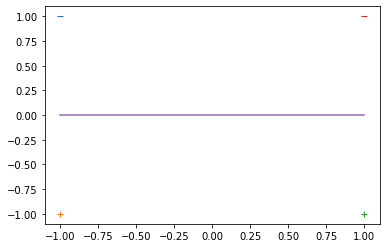

In [4]:
# YOUR CODE HERE
pts = [
    ([-1,-1],-1),
    ([-1,1],1),
    ([1,-1],1),
    ([1,1],-1)
]
for x,y in pts:
    plt.plot([x[0]],[x[0]*x[1]],marker='+' if y==1 else '_')
plt.plot([-1,1],[0,0])

The maximum margin is 1.

### Part 2 [5 points]
Plot the separating line of **Part 1** back in the original Euclidean input space.

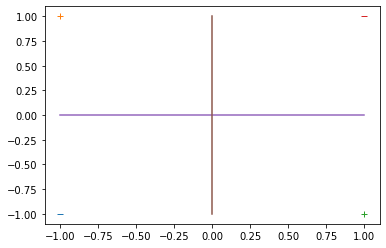

In [5]:
# YOUR CODE HERE
for x,y in pts:
    plt.plot([x[0]],[x[1]],marker='+' if y==1 else '_')
plt.plot([-1,1],[0,0])
plt.plot([0,0],[-1,1])

### Part 3 [5 points]
Is the separator in **Part 1** linear? Is the one in **Part 2** linear? Explain your answer.

The separator in part 1 is linear, because it is just a horizontal line. In part 2, however, the separator is $x_1x_2=0$, which consists of 2 lines, and is thus not linear.

### Part 4 [10 points]
The key point of the so-called “kernel trick” in SVMs is to learn a classifier that effectively separates the training data in a higher dimensional space without having to explicitly compute the representation $\phi(\mathbf{x})$ of every point $\mathbf{x}$ in the original input space. Instead, all the work is done through the kernel function $K(\mathbf{x}_i, \mathbf{x}_i)$, for example, we can use $K(\mathbf{x}_i, \mathbf{x}_i) = \phi(\mathbf{x}_i)\phi(\mathbf{x}_j)$.

Show how to compute the squared Euclidean distance in the projected space between any two points $\mathbf{x}_i$, $\mathbf{x}_j$ in the original space without explicitly computing the $\phi$ mapping, instead using the kernel function $K$. In other words, derive $d(\phi(\mathbf{x}_i), \phi(\mathbf{x}_j))$ into a form using only the kernel function.

Please remember to simplify your solution.

$d(\phi(x_i), \phi(x_j))=||\phi(x_i)-\phi(x_j)||^2=(\phi(x_i)-\phi(x_j))\cdot(\phi(x_i)-\phi(x_j))=\phi(x_i)\cdot\phi(x_i)+\phi(x_j)\cdot\phi(x_j)-2\phi(x_i)\phi(x_j)=\boxed{K(x_i,x_i)+K(x_j,x_j)-2K(x_i,x_j)}$

[30 points] Problem 3 - SVM with `sklearn`
---

In this problem, you will get familiar with important practical functions in scikit-learn such as pipeline, grid search, and cross validation. You will experiment with these using support vector machines.

Note that grid search can take some time on your laptop, so make sure that your code is correct with a small subset of the training data and search a reasonable number of options.

* Use the Sklearn implementation of support vector machines to train a classifier to distinguish Positive and negative sentiments
* Experiment with linear, polynomial, and RBF kernels. First, perform a GridSearch over each kernel function and a small set of parameters defined over a wide range to help narrow down the search space.
* Then choose the best performing kernel from your coarse scale search and define a narrower set of parameters for random search to further optimize the hyperparameters. Comment on the experiments you ran and optimal hyperparameters you found.
Hint: http://scikit-learn.org/stable/modules/grid_search.html
* Evaluate classification performance for each model for optimal parameters by testing on a hold-out set.

Following is a dataset containing reviews and sentiments associated with it.

We will create a SVM Classifier to predict positive or negative sentiments.

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
reviews  = pd.read_csv('./data/reviews.csv')
train, test = train_test_split(reviews, test_size=0.2, random_state=5622)
X_train = train['reviews']
X_test = test['reviews']
y_train = train['sentiment']
y_test = test['sentiment']

# Print some data info
print(f'[Sizes] train: {len(X_train)}, test: {len(X_test)}')
print(f'[Avg S] train: {sum(y_train)/len(X_train)}, test: {sum(y_test)/len(X_test)}')

[Sizes] train: 4000, test: 1000
[Avg S] train: 0.49875, test: 0.505


In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

# download nltk data
nltk.download('stopwords')
en_stopwords = set(stopwords.words("english")) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\null\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Part 1 [5 points]

Complete the `get_vectorizer` and `get_kfolds` functions below.

- Use [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to vectorize reviews as dictionary of term frequencies.
- Define the crossvalidation split using [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html?highlight=stratifiedkfold#sklearn.model_selection.StratifiedKFold).

In [8]:
def tokenize(text): 
    """
    Separate text into tokens
    """
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def get_vectorizer():
    """ 
    
    Create and return a CountVectorizer
    
    Hints:
        Read docs on CountVectorizer to set arguments (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) 
        Pass the above tokenize function as the tokenizer.
        Use en_stopwords variable above as stopwords
        
        Play with different parameters.
        min_df argument can help with generalizability
    """
    
    # YOUR CODE HERE
    vectorizer = CountVectorizer(
        tokenizer=tokenize,
        stop_words=en_stopwords,
    )
    return vectorizer

def get_kfolds():
    """ 
    Split dataset into 5 splits using StratifiedKFold 
    
    Hint:
    Remember to shuffle
    """
    # YOUR CODE HERE
    kfolds = StratifiedKFold(
        shuffle=True
    )
    return kfolds


vectorizer = get_vectorizer()
kfolds = get_kfolds()

In [9]:
# for grading; please ignore

### Part 2 [10 points]
* Create a pipeline with our `CountVectorizer` object in **Part 1** and an SVM Classifier.
* Create and fit a `GridSearchCV` object with the following parameter values:
  * Linear kernel, $C = 0.01, 1.0, 10.0$
  * Polynomial kernel, $\text{degree} = 2, 3$, $\gamma = 0.1, 0.5, 1$
  * RBF kernel, $\gamma = 0.1, 0.5, 1$
* Report accuracy on the best estimator from our `GridSearchCV` object.

In [10]:
def get_pipeline(**kwargs):
    """
        Define pipeline using make_pipeline (see sklearn docs) with vectorizer and SVM Classifier. 
        
        The SVM Classifer should take in all kwargs passed (passing kwargs can be achieved with fn(**kwargs))
        You should use balanced class weights for SVM.
    """
    
    # YOUR CODE HERE
    pipeline_svm = make_pipeline(vectorizer, SVC(**kwargs, class_weight='balanced'))
    return pipeline_svm

def get_course_params():
    """
        Create the grid search parameters defined above for course grid search. 
        Returns a list of dictionaries to be passed as argument to GridSearchCV below
    """
    
    # YOUR CODE HERE
    param_grid = [
        {
            'svc__C':[.01,1.0,10.0],
            'svc__kernel':['linear']
        }, {
            'svc__kernel':['poly'],
            'svc__degree':[2,3],
            'svc__gamma':[.1,.5,1.0]
        }, {
            'svc__kernel':['rbf'],
            'svc__gamma':[.1,.5,1.0]
        }
    ]
    return param_grid

def get_grid_svm():
    """
        Create GridSearchCV with pipeline and the grid search parameters given above using "accuracy" for scoring.
    """ 
     
    param_grid = get_course_params()
    pipeline_svm = get_pipeline()
    #print(pipeline_svm.get_params()['svc'].get_params().keys())
    # YOUR CODE HERE
    grid_svm = GridSearchCV(
        estimator=pipeline_svm,
        param_grid=param_grid,
        scoring='accuracy',
    )
    
    return grid_svm
    
    

grid_svm = get_grid_svm()
# For debugging purposes, it makes sense to use a smaller set of training set to speed up the grid search progress
# refit is not necessary since by default refit is true in GridSearchCV, 
# but we did this to show that you need to use the best parameter to fit the whole training set
_ = grid_svm.fit(X_train, y_train)

In [11]:
# For grading; please ignore.

In [12]:
best_params = None
best_score = None

# Store best parameters and CV score from grid search for reporting into the variables above
# YOUR CODE HERE
best_params = grid_svm.best_params_
best_score = grid_svm.best_score_

# Report best parameters and CV score from grid search
print(f'best params: {best_params} | best cv score: {best_score}')

best params: {'svc__C': 0.01, 'svc__kernel': 'linear'} | best cv score: 0.8745


In [13]:
# For grading; please ignore.

### Part 3 [10 points]

Choose the best performing kernel and parameter values from your coarse scale grid search and use them to set up a narrower range of parameter values. We will use randomized grid search to sample a fixed number of these candidate parameter sets for cross validation. The number of sampled parameter sets `n_iter` provides a trade-off between computational cost and quality of the "optimal" parameters. Feel free to experiment with different values of this parameter, but please change it back to `n_iter = 5` before submitting your assignment.

In [14]:
def get_params_fine_scale():
    """
        Set param_grid to a dictionary containing parameter values for fine scale search.
        Return value is passed as argument to RandomizedSearchCV below
    """ 
    # YOUR CODE HERE
    from scipy.stats import uniform
    param_grid = {'svc__kernel':['linear'], 'svc__C':uniform(scale=.02)}
    return param_grid

def get_random_svm():
    """
        Create randomized parameter search over fine scale grid;
        Do NOT change the value of n_iter in the submitted version of your notebook.
    """ 
    n_iter = 5
    pipeline_svm = get_pipeline()
    param_grid = get_params_fine_scale()

    random_svm = RandomizedSearchCV(
        pipeline_svm,
        param_grid,
        n_iter=n_iter,
        cv = kfolds,
        scoring="accuracy",
        verbose=1,   
        n_jobs=-1
    )
    return random_svm

random_svm = get_random_svm()
# refit is not necessary since by default refit is true in RandomSearchCV, 
# but we did this to show that you need to use the best parameter to fit the whole training set
_ = random_svm.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   50.9s finished


In [15]:
best_params = None
best_score = None

# Store best parameters and score from random search for reporting into the variables above 
# YOUR CODE HERE
best_params = random_svm.best_params_
best_score = random_svm.best_score_

# Report best parameters and score from random search
print(f'best params: {best_params} | best cv score: {best_score}')

best params: {'svc__C': 0.015100632923830746, 'svc__kernel': 'linear'} | best cv score: 0.8755


In [16]:
# For grading; please ignore.

In [17]:
def report_results(model, X, y):
    # Reports various model metrics.  
    pred = model.predict(X)        
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [18]:
# get test metrics.
report_results(random_svm.best_estimator_, X_test, y_test)

{'f1': 0.8756121449559255,
 'acc': 0.873,
 'precision': 0.8662790697674418,
 'recall': 0.8851485148514852}

### Part 4 [5 points]

Explain the overall procedure, and report the final result including which hyperparameter values were chosen. Make sure to explain your reasoning in choosing a refined parameter search space in **Part 3**.

The overall procedure was to try training the SVM with several different hyperparameters and pick the one with the highest average cross-validation accuracy. The final result was a linear classifier with hyperparameters C=0.00977890538917479. 

The refined parameter search spaced was chosen based on the fact that the best model from part 2 was a linear classifier with C=.01. Thus, I tried linear classifiers with C near 0.01 - specifically, C was chosen uniformly between 0 and 0.02.

### Extra Credit [10 points] Advanced Hyperparameter Optimization
While Grid Search and Random Search are tried and true methods for hyperparameter optimization, they are often very computationally expensive on larger models. Here you will explore a more advanced approach such as Bayesian Optimization or Tree-structured Parzen estimators (TPE). These algorithms are more complex, but there are packages that abstract away the complications. 

The general idea of these methods is to focus on the "good" areas of the hyperparameter space, and quickly rule out the bad areas. 

This extra credit is fairly open-ended, and meant to allow you to explore other hyperaparameter optimization methods outside the scikit-learn environment. Exploring this now will be **very helpful for your final project**. 

Here are some package recommendations:
- [wandb](https://docs.wandb.com/): An alternative to TensorBoard. You can do hyperparameter optimization with sweeps. 
- [ray.tune](https://docs.ray.io/en/latest/tune/): Great package for large hyperparameter sweeps with great parallelization. The Hyperopt search algorithm is especially useful.

Any package is okay, but **please make sure to leave an install command for us in the cell below so that we can install it automatically**.

```python
!pip install ray[tune]
```

The main criteria are that you use one of the following search algorithms (https://docs.ray.io/en/latest/tune/api_docs/suggestion.html):
- Bayesian Optimization
- Tree-structured Parzen estimators (TPE)
- Adaptive TPE
- Population Based Training (PBT)

Additionally, you should optimize over the **course parameters** defined in part 2. However, instead of using a fixed categorical parameter space, you should choose ranges as follows.

| Kenel| Parameter | space type | min | max |
| --------- | ---------- | --- | --- | ---- |
| Linear kernel | $C$ | log uniform | exp(-3) | exp(3)| 
| Polynomial kernel | degree| int uniform | 1 | 5| 
| Polynomial kernel | $\gamma$ | uniform | 0.01 | 1 | 
 RBF kernel | $\gamma$ |  uniform | 0.01 | 1 | 

Fine-Tuning will be done automatically, which is the beauty of these methods, but make sure to run enough trials that you consistently score better than your previous solutions.

We've laid out a template for using ray.tune and hyperopt, but feel free to change to a different package if you prefer.

Note that when using a search algorithm like hyperopt, you should always wrap your algorithm in a `ConcurrencyLimiter` where the number of concurrent trials is a small fraction of the total number of trials.

In [ ]:
# install package here
# !pip install ray[tune] -q
# !pip install hyperopt

# import any packages here
from sklearn.model_selection import cross_val_score

from ray import tune
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.suggest.hyperopt import HyperOptSearch
from hyperopt import hp


def objective(config):
    """ 
        This is an objective function for ray.tune.
    """
    
    config=config['outer']
    
    # Now, train the SVM
    model = get_pipeline(**config)
    kfolds = get_kfolds()
    score = cross_val_score(model, X_train, y_train, cv=kfolds, scoring='accuracy')
    tune.report(accuracy=score.mean())

# TODO: Define the parameter space and your search algorithm 
# YOUR CODE HERE
raise NotImplementedError()


# Run ray.tune (make sure to play around with the number of trials. It's small here to get you going)
analysis = tune.run(
    objective, 
    search_alg=algo, 
    num_samples=32, 
    verbose=1
)

In [ ]:
# TODO: Report best parameters as before
best_params = None
best_score = None
 
# YOUR CODE HERE
raise NotImplementedError()

# Report best parameters from hyperparameter optimization
print(f'best params: {best_params} | best score: {best_score}')

### Optional survey.
***

We are always interested in your feedback. At the end of each homework, there is a simple anonymous feedback [survey](https://docs.google.com/forms/d/e/1FAIpQLSe6yaRaEmShRe9DqYE66UA4PJtQTgkS6vloXyOKb7WuFFSYrQ/viewform?usp=pp_url) to solicit your feedback for how to improve the course.